In [1]:
machine = 'mac'
machine = 'magny'

Ngalrad = 4.
dR = 1# kpc
dz = 2# kpc

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
## density
istars, = np.where( (s.type == 4) & (s.halo == 0) & (s.r() > 0.) & (s.r() < Ngalrad*s.galrad) )
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, istars)

In [5]:
def dens(M, R, z, dR, dz):
    
    Rmin, Rmax = np.min(R), np.max(R)
    if Rmin == 0.:
        Rmin = np.sort(R)[1]
    zmin, zmax = np.min(z), np.max(z)
    if zmin == 0.:
        zmin = np.sort(z)[1]    
    print('Rmin:', Rmin, 'Rmax:', Rmax, 'dR:', dR)
    print('zmin:', zmin, 'zmax:', zmax, 'dz:', dz)
    Rbins, zbins = np.arange(Rmin, Rmax, dR), np.arange(zmin, zmax, dz)
    mbins, volbins = np.zeros((len(Rbins), len(zbins))), np.zeros((len(Rbins), len(zbins))) 
    rho_arr_real, rho_arr_mean = np.zeros(len(R)), np.zeros(len(R))
    for i in range(len(Rbins)):
        for j in range(len(zbins)):
            if i == 0:
                if (j < len(zbins) - 1):
                    inbin = (0 <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (0 <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j)    
            elif (i > 0) & (i < len(Rbins) - 1):
                if j < len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j)
            elif i == len(Rbins) - 1:
                if j < len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < (Rbins[i] + dR)) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < (Rbins[i] + dR)) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j, len(Rbins), i)
            else:
                print(len(Rbins), i)
             

    rho = mbins/volbins
    return(rho, rho_arr_real, rho_arr_mean, Rbins, zbins)

In [6]:
rho, rho_arr_real, rho_arr_mean, Rbins, zbins = dens(s.mass[istars], 1000*R, 1000*z, dR, dz)

Rmin: 0.000591963 Rmax: 96.3116 dR: 1
zmin: -93.2023 zmax: 94.9756 dz: 2


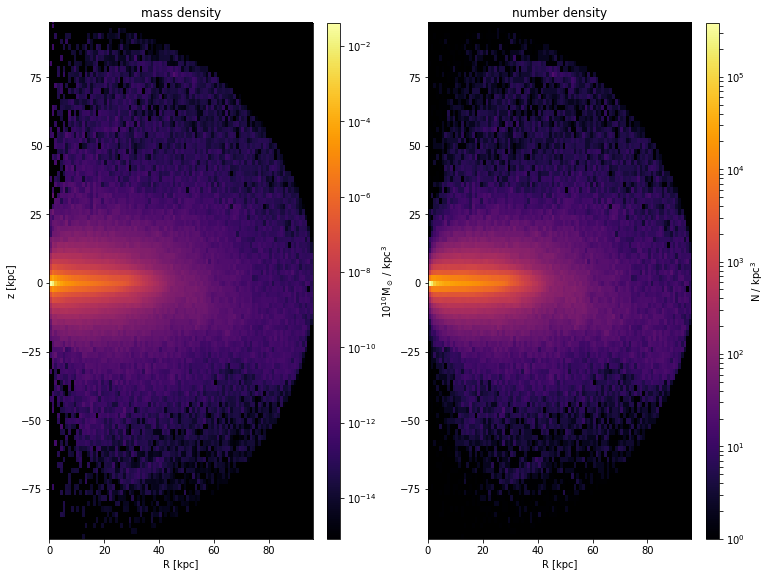

In [7]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.3, hspace=None)
h1 = ax1.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], weights = rho_arr_mean, norm=matplotlib.colors.LogNorm(), cmap = cmap)#, \
           #range = [[0, 25], [-25, 25]])
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("z [kpc]")
ax1.set_aspect('equal')
ax1.set_title("mass density")
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
cbar1 = fig.colorbar(h1[3], cax=cax1)
cbar1.set_label('$10^{10}\mathrm{M}_\odot\ /\ \mathrm{kpc}^3$')

h2 = ax2.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax2.set_xlabel("R [kpc]")
#ax2.set_ylabel("z [kpc]")
ax2.set_aspect('equal')
ax2.set_title('number density')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
cbar2 = fig.colorbar(h2[3], cax=cax2)
cbar2.set_label('$\mathrm{N}\ / \ \mathrm{kpc}^3$')
 
#fig.savefig('../plots/au24_densities.png', dpi = 300, format = 'png', bbox_inches = 'tight')

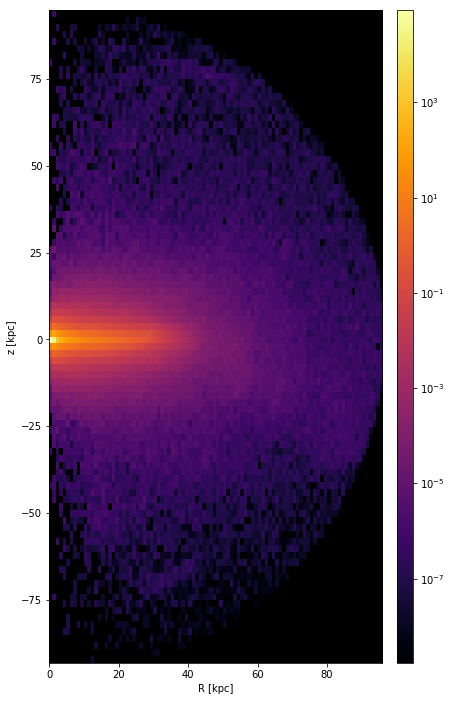

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
h = ax.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], weights = np.array(rho_arr_real), norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [9]:
print(np.max(rho), np.min(rho))
print()

0.219298686093 0.0



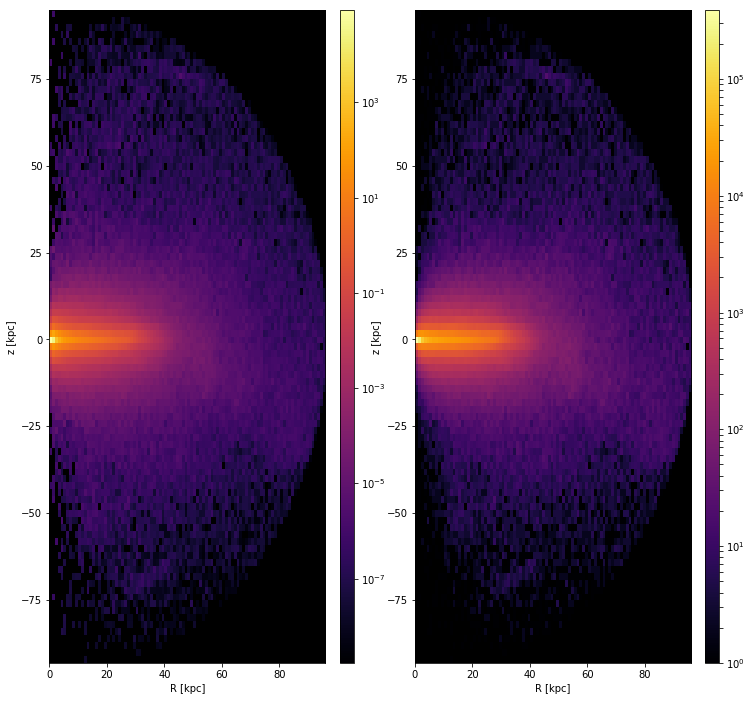

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
h1 = ax1.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], weights = rho_arr_real, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h1[3], cax=cax1)
h2 = ax2.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h2[3], cax=cax2)

In [11]:
print(rho_arr_mean)

[  1.06526725e-07   1.06526725e-07   1.06526725e-07 ...,   3.34668262e-11
   2.68065381e-12   1.17092305e-11]


In [12]:
print(rho_arr_real)

[  2.19298686e-01   2.19298686e-01   2.19298686e-01 ...,   6.88956785e-05
   5.51846364e-06   2.41049264e-05]


In [13]:
#np.savetxt('rhodata.txt', np.column_stack((rho_arr_mean, rho_arr_real)), header=('rho_mean, rho_real'))

In [14]:
print(np.min(rho_arr_mean), np.max(rho_arr_mean))

8.30513339598e-16 1.06526725152e-07
